In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from optimizers.adam_clara import Adam_CLARA
from optimizers.sgd_clara import SGD_CLARA

In [2]:
noise_std = 0.1

def sphere(x):
    noise = torch.randn_like(x) * noise_std # Gaussian noise
    return torch.sum((x + noise)**2)

def ellipsoid(x):
    n = x.shape[0]
    c = torch.logspace(0, 6, steps=n, base=10, dtype=x.dtype, device=x.device)
    noise = torch.randn_like(x) * noise_std # Gaussian noise
    return torch.sum(c * (x + noise) ** 2)

def get_full_path_vector(optimizer):
    mu = optimizer.param_groups[0].get('mu', None)
    paths = []
    for group in optimizer.param_groups:
        for p in group['params']:
            if p in optimizer.state and 'path' in optimizer.state[p]:
                path = optimizer.state[p]['path']
                paths.append(path.clone().detach())
    if paths:
        full_path = torch.cat([p.view(-1) for p in paths]).cpu().numpy()
        return (full_path @ full_path) / mu  # Return squared path norm divided by expected squared norm of path of uniform random vectors
    return None

def optimize(f, x0, lr0, budget, algorithm=SGD_CLARA, adapt_lr=True, unit_step_direction=True):
    x = torch.tensor(x0, requires_grad=True)
    if adapt_lr is None:
        optimizer = algorithm([x], lr=lr0)
    else:
        optimizer = algorithm([x], lr=lr0, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

    # Keep track of candidate solutions and learning rates during optimization
    candidate_sol = []
    lr = []
    path_norm = []

    # Optimization loop
    for step in range(budget):
        optimizer.zero_grad() # Clear previous gradients
        loss = f(x) # Compute loss
        loss.backward() # Compute gradients
        optimizer.step() # Update parameters

        lr.append(optimizer.param_groups[0]['lr'])
        candidate_sol.append(x.clone().detach())
        path_norm.append(get_full_path_vector(optimizer))

        # TODO: Collect cumulative path info

    return candidate_sol, lr, path_norm

In [5]:
dim = 2
x0 = 100 * np.ones(dim)
lr0 = 1e-1
budget = 3000
adapt_lr = True
unit_step_direction = True

choice = 1

f = sphere

# Create plot title for display/saving on disk
if choice == 0:  # SGD_CLARA
    optimizer = SGD_CLARA
    fig_title = 'SGD'
    fig_name = 'sgd_'
elif choice == 1:  # Adam_CLARA
    optimizer = Adam_CLARA
    fig_title = 'Adam'
    fig_name = 'adam_'
elif choice == 2:  # PyTorch SGD
    optimizer = SGD
    adapt_lr = None
    fig_title = 'torch_SGD'
    fig_name = 'torch_sgd_'
else:  # PyTorch Adam
    optimizer = Adam
    adapt_lr = None
    fig_title = 'torch_Adam'
    fig_name = 'torch_adam_'

if adapt_lr:
    fig_title += ' with CLARA'
    fig_name += 'clara_'

if noise_std > 0:
    f_name = r'\tilde{f}'
else:
    f_name = r'f'

if f is sphere:
    f_name = fr'${f_name}_\text{{sphere}}$'
    fig_name += 'sphere_noisy_'
elif f is ellipsoid:
    f_name = fr'${f_name}_\text{{ellipsoid}}$'
    fig_name += 'elli_noisy_'

fig_name += 'lr0_' + str(lr0)

candidate_sol, learning_rates, path_ratios = optimize(f, x0, lr0, budget, algorithm=optimizer, adapt_lr=adapt_lr, unit_step_direction=unit_step_direction)

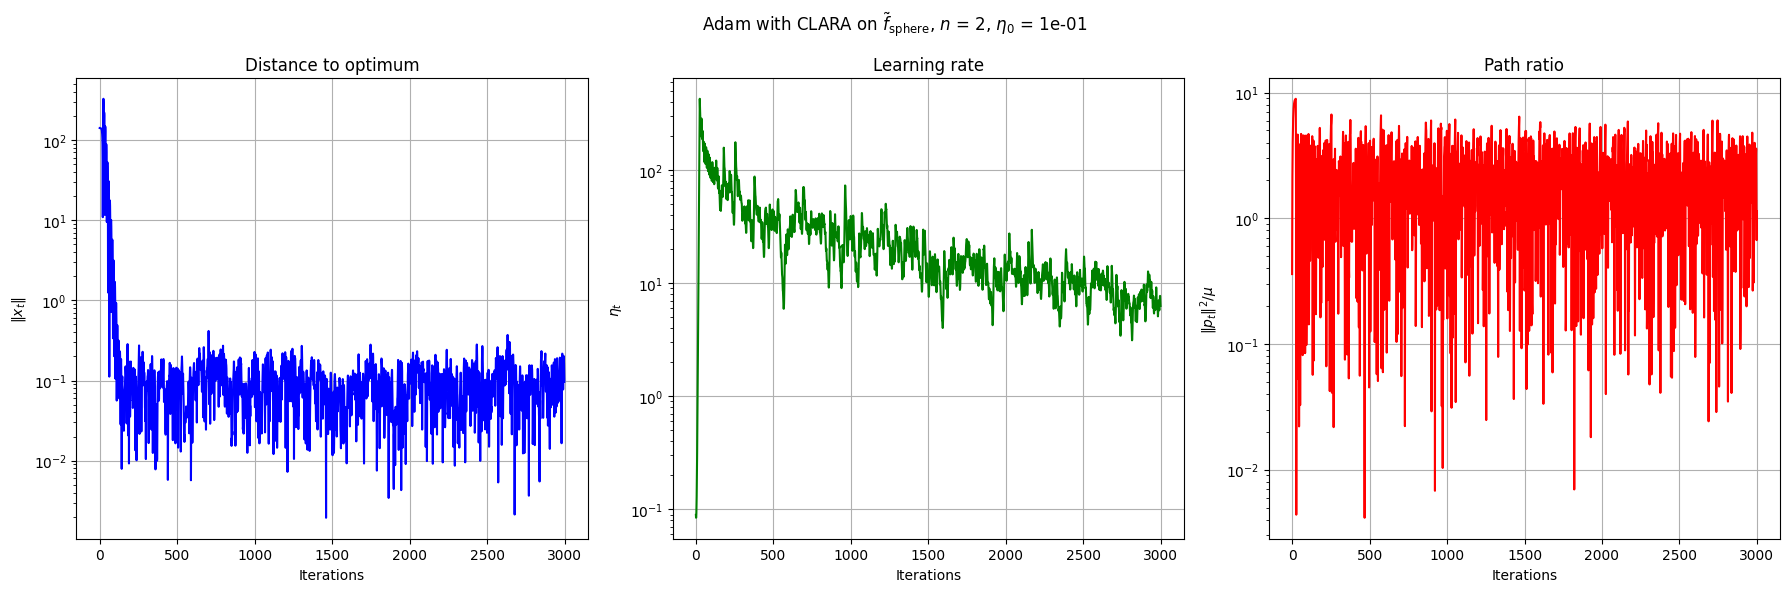

In [4]:
results = [[np.linalg.norm(x) for x in candidate_sol],
           learning_rates,
           path_ratios
           ]
fig_titles = ['Distance to optimum',
              'Learning rate',
              'Path ratio'
              ]
y_labels = [r'$\|x_t\|$',
            r'$\eta_t$',
            r'$\|p_t\|^2 / \mu$'
            ]
colors = ['b',
          'g',
          'r'
          ]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 2 rows, 2 columns
fig.suptitle(rf'{fig_title} on {f_name}, $n$ = {str(len(x0))}, $\eta_0$ = {lr0:.0e}')

for i, ax in enumerate(axes.flat):  # Iterate over subplots
    ax.semilogy(results[i], color=colors[i])
    ax.set_title(fig_titles[i])
    ax.set_xlabel('Iterations')
    ax.set_ylabel(y_labels[i])
    ax.grid(True)

# Adjust layout and show
plt.tight_layout()
# plt.savefig(fig_name + '.pdf')
plt.show()